In [ ]:
import getpass
import os
import re
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
# from langchain_anthropic import ChatAnthropic                                         #### commented for the test run
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_mistralai import ChatMistralAI
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv


load_dotenv()  # This loads variables from .env into the environment
# MISTRAL_SMALL_REGIOIT_API_KEY = os.getenv("MISTRAL_SMALL_REGIOIT_API_KEY")
# MISTRAL_SMALL_REGIOIT_API_ENDPOINT = os.getenv("MISTRAL_SMALL_REGIOIT_API_ENDPOINT")
# MISTRAL_LARGE_REGIOIT_API_KEY = os.getenv("MISTRAL_LARGE_REGIOIT_API_KEY")
# MISTRAL_LARGE_REGIOIT_API_ENDPOINT = os.getenv("MISTRAL_LARGE_REGIOIT_API_ENDPOINT")
# GPT4o_REGIOIT_API_KEY = os.getenv("GPT4o_REGIOIT_API_KEY")
# # GPT4o_REGIOIT_API_ENDPOINT = os.getenv("GPT4o_REGIOIT_API_ENDPOINT")
# TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
# edwin_openai_api_key = os.getenv("OPENAI_API_KEY")


# def _set_if_undefined(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"Please provide your {var}")


# _set_if_undefined("ANTHROPIC_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

In [1]:
# edwin_openai_api_key

## the new approach for the multi agentic approach


In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults                               ## at the moment commented to make for test run
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search.tool import TavilySearchResults

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)` and save it as .png in local directory with the name "image_file.png". This is visible to the user. """
    try:
        print(f""" following is the code from the LLM {code}
        """)
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## read the data


In [3]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

df = pd.read_csv ("dataframe.csv")

# df1 = pd.read_csv ("gdf0.csv")
# df2= pd.read_csv ("gdf1.csv")

In [19]:
### the llm initaiton

llm = ChatOpenAI(temperature=0.1, model_name="gpt-4o", api_key = edwin_openai_api_key)

## the creation of supervisor agent

In [ ]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages
from typing_extensions import TypedDict

class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [20]:
### the supervisor agent###

research_supervisor_node = make_supervisor_node(llm, ["python_repl_tool"])

NameError: name 'TypedDict' is not defined

In [ ]:
# def make_system_prompt(suffix: str) -> str:
#     return (
#         "You are a helpful AI assistant, collaborating with other assistants."
#         " Use the provided tools to progress towards answering the question."
#         " If you are unable to fully answer, that's OK, another assistant with different tools "
#         " will help where you left off. Execute what you can to make progress."
#         " If you or any of the other assistants have the final answer or deliverable,"
#         " prefix your response with FINAL ANSWER so the team knows to stop."
#         f"\n{suffix}"
#     )

In [ ]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
# from langchain_anthropic import ChatAnthropic                                         #### commented for the test run
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_mistralai import ChatMistralAI
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(temperature=0.1, model_name="gpt-4o", api_key = GPT4o_REGIOIT_API_KEY)


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto



# Research agent and node
visualization_agent = create_pandas_dataframe_agent(
    llm,
    tools=[python_repl_tool],                                                               #### commented just only for a test run
    df=df,
    verbose=True,
    allow_dangerous_code=True,
    prompt=make_system_prompt(
        "You can only do research for filtering the upcoming data, to optimize the token cost. You are working with a chart generator colleague."
        "to filter the data to be analyzed please use the Dataframe Head df.head() to save the token cost "
        "in the dataframe column geometry contains the information of longitude coordinate and latitude coordinate"
        "in the column geometry, it contains irrelevant string 'POINT Z'"
        "in the column geometry, the coordinate is informed such follow (longitude, altitude)"
        "in the dataframe, column GEP_X is for the longitude coordinate"
        "in the dataframe, column GEP_Y is for latitude coordinate"
        "the row id  is column id_FB36"
    ),
)

###########################################################################################



def visualization_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = visualization_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )




c:\Users\edwin.hartarto\Anaconda3\envs\komm_it_regio_it\Lib\site-packages\langchain_experimental\agents\agent_toolkits\pandas\base.py:283: UserWarning: Received additional kwargs {'tools': [StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)` and save it as .png in local directory with the name "image_file.png". This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x000001E309D9DDA0>)], 'prompt': "You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with F

### Define the Graph

We can now put it all together and define the graph!

In [ ]:
# from langgraph.graph import StateGraph, START

# workflow = StateGraph(MessagesState)
# workflow.add_node("viz", visualization_node)
# workflow.add_edge(START, "viz")
# graph = workflow.compile()

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.



> Entering new AgentExecutor chain...
Thought: To create a Cartesian graph using the specified columns, I will plot the `GEP_X` values on the x-axis and the `GEP_Y` values on the y-axis. The row ID can be used as labels for each point. I will use matplotlib to create the plot.
Action: python_repl_ast
Action Input: 
```python
import matplotlib.pyplot as plt

# Extract relevant columns
x = df['GEP_X']
y = df['GEP_Y']
labels = df['Unnamed: 0']

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y)

# Annotate each point with its row ID
for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]))

plt.title('Cartesian Graph of GEP_X vs GEP_Y')
plt.xlabel('GEP_X (Longitude)')
plt.ylabel('GEP_Y (Latitude)')
plt.grid(True)
plt.show()
```

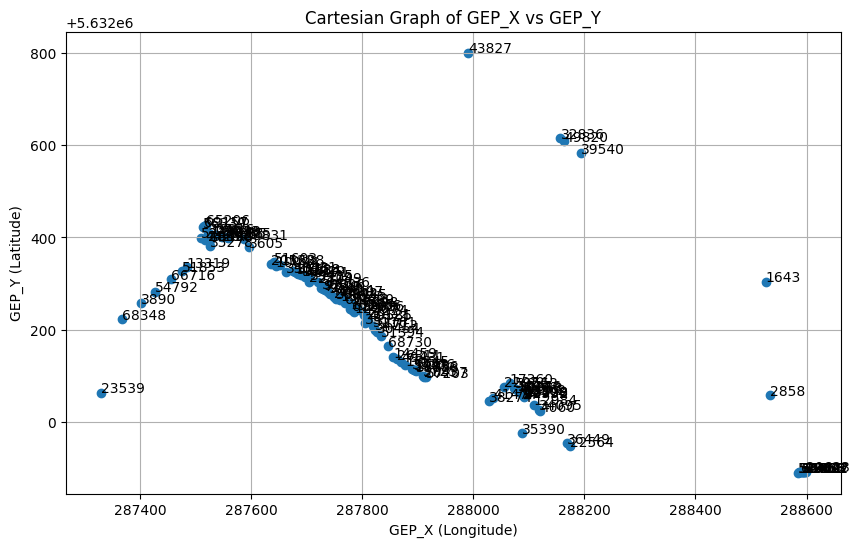

I have created a Cartesian graph using the `GEP_X` and `GEP_Y` columns, with each point labeled by its row ID. The x-axis represents the longitude (`GEP_X`), and the y-axis represents the latitude (`GEP_Y`). The graph is displayed with grid lines for better readability. 

Final Answer: A Cartesian graph has been created using the `GEP_X` and `GEP_Y` columns, with points labeled by their row IDs.

> Finished chain.


In [ ]:
result = visualization_agent.invoke(
    "for this session the relevant column are  GEP_X, GEP_Y and row ID, please make cartesian Graph based on these column !"
    )


The CSV Agent Approach to filter the incoming data and optimize the Token 

Grounding about this : CSV_agent

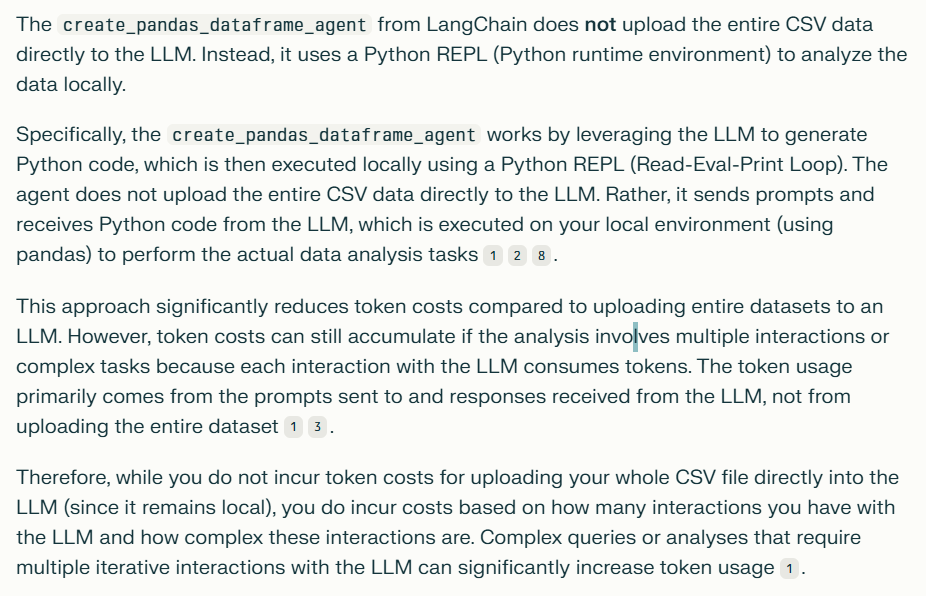

![image.png](attachment:image.png)